In [1]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.utils import plot_model
import random

## Define Constants

In [2]:
batch = 32
dim = 256
train_dir = "/kaggle/input/imagenet/imagenet/train"
val_dir = "/kaggle/input/imagenet/imagenet/val/"

print("Found", len(os.listdir(train_dir)), "files in training dir.")
print("Found", len(os.listdir(val_dir)), "files in validation dir.")

Found 45000 files in training dir.
Found 5000 files in validation dir.


## Define dataset

In [3]:
def make_generator(path):
    def generate():
        for i in os.listdir(path):
            img = cv2.imread(os.path.join(path, i))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, dsize=(dim, dim))
            img = img / 255.
            yield img, img
    
    return generate

In [4]:
train_generator = tf.data.Dataset.from_generator(
    make_generator(train_dir),
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([dim, dim, 3]), tf.TensorShape([dim, dim, 3]))
).batch(batch)

val_generator = tf.data.Dataset.from_generator(
    make_generator(val_dir),
    output_types=(tf.float32, tf.float32),
    output_shapes=(tf.TensorShape([dim, dim, 3]), tf.TensorShape([dim, dim, 3]))
).batch(batch)

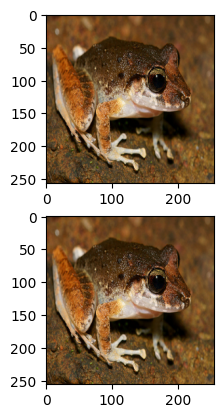

In [5]:
for x in train_generator.take(1):
    plt.figure()
    plt.subplot(211)
    plt.imshow(x[0][0])
    plt.subplot(212)
    plt.imshow(x[1][0])

## Define model

In [6]:
def encode_block(n, f):
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(n, (f, f), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(n, (f, f), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D((2, 2), padding='same')
    ])

def decode_block(n, f):
    return tf.keras.models.Sequential([
        tf.keras.layers.UpSampling2D((2, 2)),
        tf.keras.layers.Conv2DTranspose(n, (f, f), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2DTranspose(n, (f, f), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
    ])

def encoder():
    return tf.keras.models.Sequential([
        encode_block(32, 3),
        encode_block(64, 5),
        encode_block(128, 5),
        encode_block(256, 7)
    ], name='encoder')

def decoder():
    return tf.keras.models.Sequential([
        decode_block(256, 7),
        decode_block(128, 5),
        decode_block(64, 5),
        decode_block(3, 3)
    ], name='decoder')

def unetmodel(e, d):
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(dim, dim, 3)),
        e,
        d,
    ])

In [7]:
e = encoder()
d = decoder()

In [8]:
model = unetmodel(e, d)
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 16, 16, 256)    │     5,599,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 256, 256, 3)    │     7,964,847 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,564,623 (51.74 MB)

 Trainable params: 13,560,899 (51.73 MB)

 Non-trainable params: 3,724 (14.55 KB)

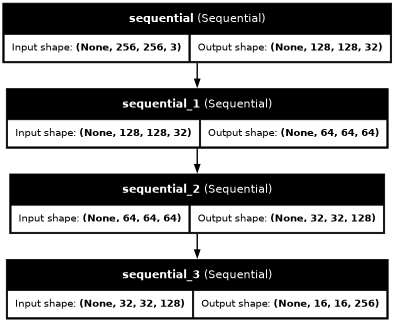

In [9]:
plot_model(e, show_shapes=True, show_layer_names=True, dpi=50)

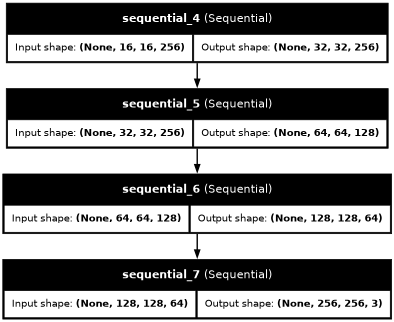

In [10]:
plot_model(d, show_shapes=True, show_layer_names=True, dpi=50)

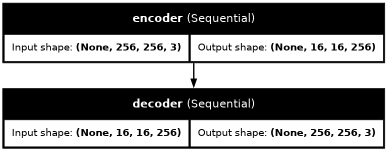

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=50)

In [12]:
def plot_history(history, acc=False):
    _num_epochs = [i for i in range(len(history.history['loss']))]
    plt.figure(figsize=(10 if acc else 6, 5))
    
    if acc:
        plt.subplot(121)
    plt.title("Loss")
    plt.plot(_num_epochs, history.history['loss'])
    plt.plot(_num_epochs, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    
    if acc:
        plt.subplot(122)
        plt.title("Accuracy")
        plt.plot(_num_epochs, history.history['accuracy'])
        plt.plot(_num_epochs, history.history['val_accuracy'])
        plt.legend(['Training', 'Validation'])
    
    plt.show()

In [13]:
model.compile(
    optimizer='adam',
    loss='mse',
)

## Training

In [14]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20


I0000 00:00:1731409840.432521      94 service.cc:145] XLA service 0x79531410c3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731409840.432603      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2024-11-12 11:11:03.009584: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,32,5,5]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,128,128]{3,2,1,0}, f32[32,64,128,128]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-12 11:11:03.040041: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.030668251s
Trying algorithm eng0{} for conv

   1407/Unknown 821s 552ms/step - loss: 0.2415

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 905s 612ms/step - loss: 0.2414 - val_loss: 0.1560
Epoch 2/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 450s 319ms/step - loss: 0.0171 - val_loss: 0.0383
Epoch 3/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 450s 320ms/step - loss: 0.0135 - val_loss: 0.0291
Epoch 4/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 450s 319ms/step - loss: 0.0117 - val_loss: 6.6238
Epoch 5/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 450s 320ms/step - loss: 0.0138 - val_loss: 0.0337
Epoch 6/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 451s 320ms/step - loss: 0.0106 - val_loss: 0.0313
Epoch 7/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 449s 319ms/step - loss: 0.0099 - val_loss: 0.0202
Epoch 8/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 450s 320ms/step - loss: 0.0095 - val_loss: 0.0162
Epoch 9/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 449s 319ms/step - loss: 0.0090 - val_loss: 2.4212
Epoch 10/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 449s 319ms/step - loss: 0.0083 - val_loss: 0.0101
Epoch 11/20
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 451s 321ms/step - loss: 0.0078 - val_loss: 1286

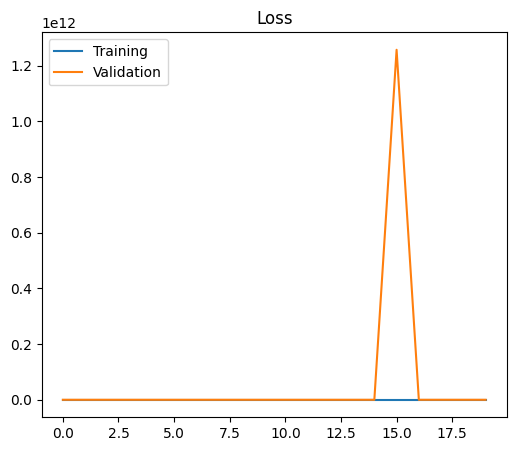

In [15]:
plot_history(history)

## Test

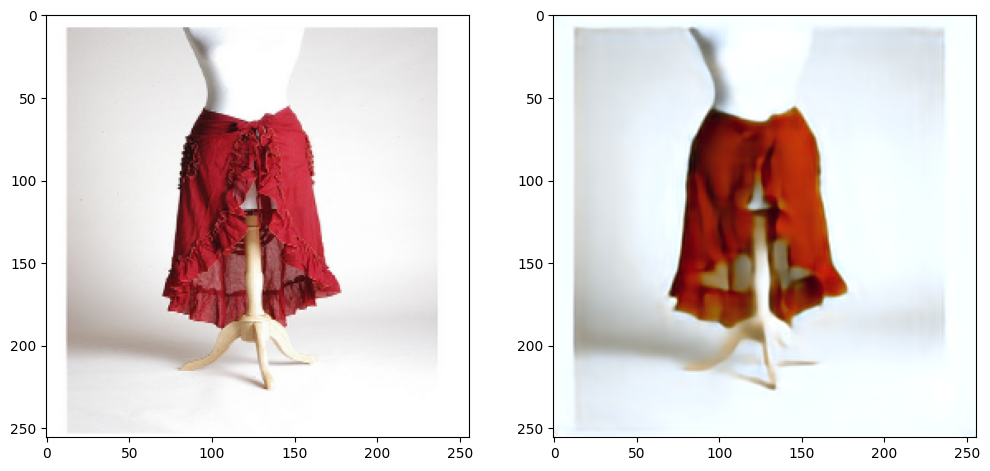

In [41]:
test = cv2.imread(os.path.join(val_dir, random.choice(os.listdir(val_dir))))
test = cv2.cvtColor(test, cv2.COLOR_BGR2RGB)
test = cv2.resize(test, dsize=(dim, dim))
test = test / 255.

pred = model(np.expand_dims(test, axis=0))

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(test)
plt.subplot(122)
plt.imshow(pred[0])

## Save model

In [42]:
e.save("encoder.keras")

In [43]:
d.save("decoder.keras")